# Exploring Panel for Data Science Workflows

**Author**: Andres Gomez

**Library**: Panel

**URL**: https://github.com/andresgole/OIM_7502/tree/main/Panel

**Description**:  
Panel is a powerful and flexible Python library for creating interactive web-based dashboards and data applications. 
It is especially useful for data scientists to explore, visualize, and communicate data insights effectively using a Jupyter Notebook or a Python script.


In [81]:
# Install Panel
!pip install panel

In [83]:
import panel as pn
import pandas as pd
pn.extension()

# Load dataset
df = pd.read_csv(r'C:\Users\andre\OIM7502_SP25\data\Wage.csv')

In [85]:
# Interactive data summary
column_selector = pn.widgets.Select(name='Select Column', options=list(df.columns))

@pn.depends(column_selector)
def describe_column(column):
    return df[column].describe()

pn.Column(column_selector, describe_column).servable()


Column
    [0] Select(options=['year', 'age', ...], value='year')
    [1] ParamFunction(function, _pane=DataFrame, defer_load=False)

Column
    [0] Markdown(str)
    [1] Select(name='Education Level', options=['HS Grad', 'Some College'...], value='HS Grad')
    [2] ParamFunction(function, _pane=Markdown, defer_load=False)
    [3] ParamFunction(function, _pane=Matplotlib, defer_load=False)
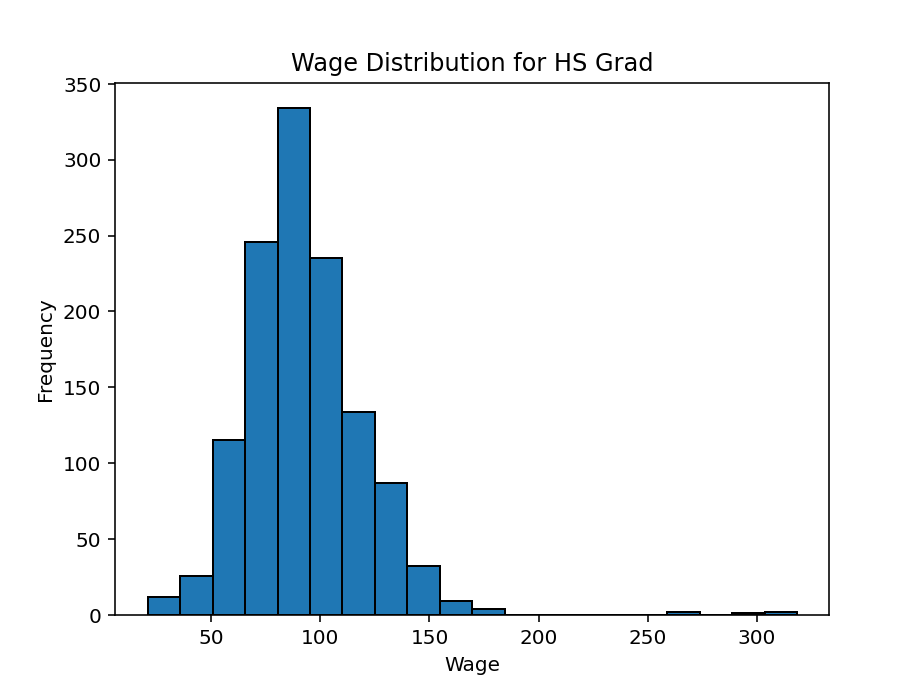

In [92]:
import panel as pn
import pandas as pd
import matplotlib.pyplot as plt

pn.extension()

# Load dataset
df = pd.read_csv(r'C:\Users\andre\OIM7502_SP25\data\Wage.csv')

# Get original values
raw_levels = df['education'].dropna().unique().tolist()
raw_levels.sort()  # Sort using original number order like "1. < HS Grad", "2. HS Grad"

# Clean each value (remove number, dot, and "<")
def clean_label(label):
    return label.split('. ')[1].replace('<', '').strip()

# Clean DataFrame column
df['education'] = df['education'].apply(clean_label)

# Build cleaned, ordered, unique list for dropdown
cleaned_levels = []
seen = set()
for raw in raw_levels:
    cleaned = clean_label(raw)
    if cleaned not in seen:
        cleaned_levels.append(cleaned)
        seen.add(cleaned)

# Dropdown widget
education_selector = pn.widgets.Select(name='Education Level', options=cleaned_levels)

# Function to display average wage
@pn.depends(education_selector)
def average_wage(edu_level):
    avg = df[df['education'] == edu_level]['wage'].mean()
    return f"The average wage for {edu_level} is ${avg:.2f} per hour"

# Function to plot histogram
@pn.depends(education_selector)
def plot_wage_distribution(edu_level):
    wages = df[df['education'] == edu_level]['wage']
    fig, ax = plt.subplots()
    ax.hist(wages, bins=20, edgecolor='black')
    ax.set_title(f'Wage Distribution for {edu_level}')
    ax.set_xlabel('Wage')
    ax.set_ylabel('Frequency')
    plt.close(fig)
    return fig

# Combine everything into one layout
pn.Column(
    "## Wage Dashboard by Education Level",
    education_selector,
    average_wage,
    plot_wage_distribution
).servable()

Column
    [0] Markdown(str)
    [1] Select(name='Plot Column', options=['wage', 'logwage'], value='wage')
    [2] ParamFunction(function, _pane=Matplotlib, defer_load=False)
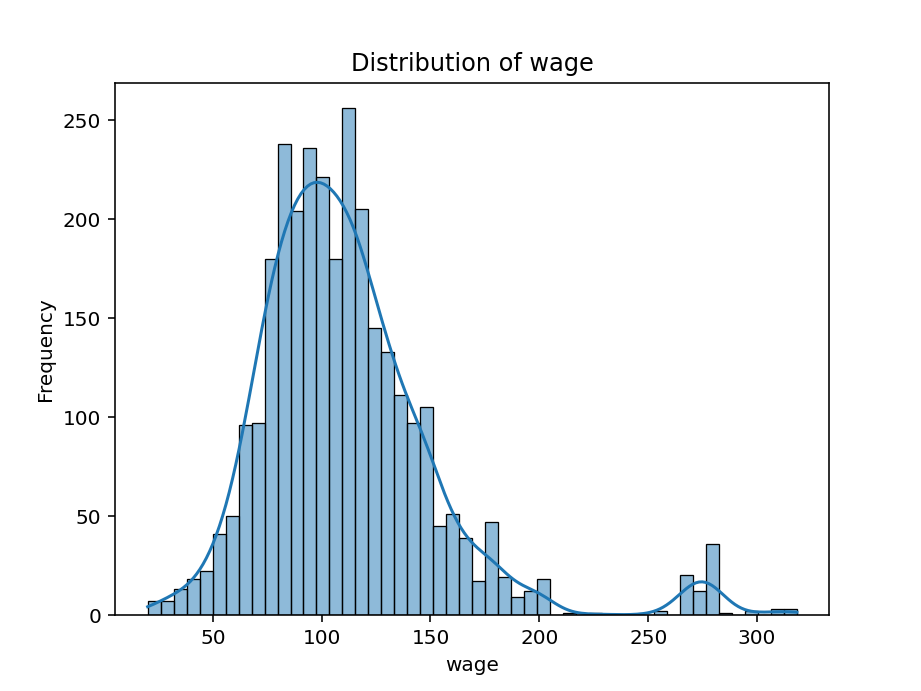

In [97]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a dropdown that only shows 'wage' and 'logwage'
column_plot = pn.widgets.Select(name='Plot Column', options=['wage', 'logwage'])

@pn.depends(column_plot)
def show_histogram(col):
    fig, ax = plt.subplots()
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f'Distribution of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    plt.close(fig)  # 👈 prevents duplicate plots
    return fig

# Combine into one Panel component
pn.Column("## Histogram Viewer", column_plot, show_histogram).servable()

Column
    [0] Markdown(str)
    [1] Row
        [0] MultiSelect(name='Education', options=['Advanced Degree', ...], size=6, value=['Advanced Degree', ...])
        [1] RangeSlider(end=2009, name='Year Range', start=2003, step=1, value=(2003, 2009), value_end=2009, value_start=2003)
        [2] IntSlider(end=80, name='Minimum Age', start=18, value=18)
    [2] Tabs
        [0] Column
            [0] ParamFunction(function, _pane=Row, defer_load=False)
        [1] ParamFunction(function, _pane=Matplotlib, defer_load=False, name='📊 Histogram')
        [2] ParamFunction(function, _pane=Matplotlib, defer_load=False, name='📈 Boxplot')
        [3] ParamFunction(function, _pane=DataFrame, defer_load=False, name='📋 Summary Stats')
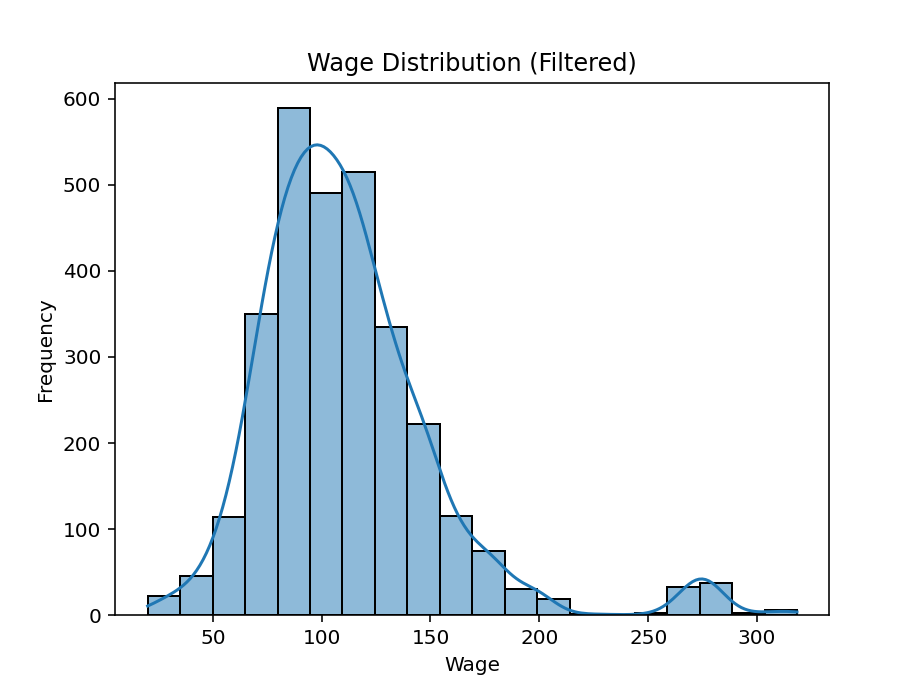
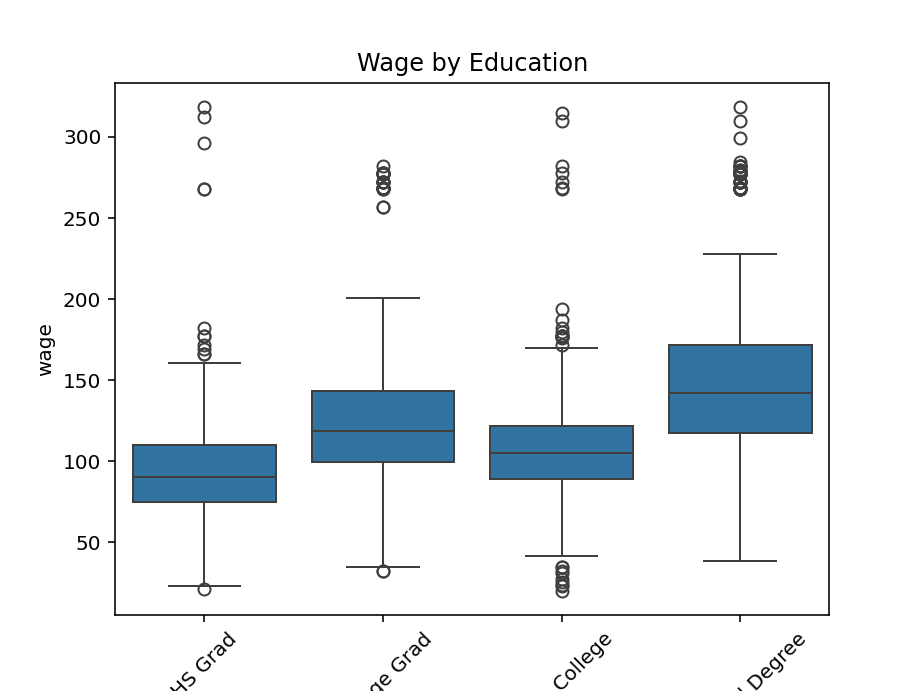

In [105]:
# ===== WIDGETS =====
education_filter = pn.widgets.MultiSelect(
    name='Education',
    options=sorted(df['education'].unique()),
    value=sorted(df['education'].unique()),
    size=6
)

year_slider = pn.widgets.RangeSlider(
    name='Year Range',
    start=df['year'].min(),
    end=df['year'].max(),
    value=(df['year'].min(), df['year'].max())
)

age_slider = pn.widgets.IntSlider(
    name='Minimum Age',
    start=df['age'].min(),
    end=df['age'].max(),
    value=df['age'].min()
)

# ===== FILTER FUNCTION =====
@pn.depends(education_filter, year_slider, age_slider)
def filtered_data(edu, year_range, min_age):
    return df[
        (df['education'].isin(edu)) &
        (df['year'] >= year_range[0]) & (df['year'] <= year_range[1]) &
        (df['age'] >= min_age)
    ]

# ===== TOP & BOTTOM 25 TABLES =====
@pn.depends(education_filter, year_slider, age_slider)
def top_bottom_tables(edu, year_range, min_age):
    data = filtered_data(edu, year_range, min_age)
    sorted_data = data.sort_values(by='wage', ascending=False)
    
    top_25 = sorted_data.head(25)[['year', 'age', 'education', 'wage']]
    bottom_25 = sorted_data.tail(25)[['year', 'age', 'education', 'wage']]
    
    return pn.Row(
        pn.Column("### 💰 Top 25 Highest Wages", top_25.reset_index(drop=True)),
        pn.Spacer(width=50),
        pn.Column("### 🪙 Bottom 25 Lowest Wages", bottom_25.reset_index(drop=True))
    )

# ===== HISTOGRAM =====
@pn.depends(education_filter, year_slider, age_slider)
def wage_histogram(edu, year_range, min_age):
    data = filtered_data(edu, year_range, min_age)
    fig, ax = plt.subplots()
    sns.histplot(data['wage'], bins=20, kde=True, ax=ax)
    ax.set_title('Wage Distribution (Filtered)')
    ax.set_xlabel('Wage')
    ax.set_ylabel('Frequency')
    plt.close(fig)
    return fig

# ===== UPDATED BOXPLOT =====
@pn.depends(education_filter, year_slider, age_slider)
def wage_boxplot(edu, year_range, min_age):
    data = filtered_data(edu, year_range, min_age)
    fig, ax = plt.subplots()
    sns.boxplot(data=data, x='education', y='wage', ax=ax)
    ax.set_title('Wage by Education')
    plt.setp(ax.get_xticklabels(), rotation=45)  # ✅ Safe rotation, no warning
    plt.close(fig)
    return fig

# ===== SUMMARY STATS =====
@pn.depends(education_filter, year_slider, age_slider)
def wage_summary(edu, year_range, min_age):
    data = filtered_data(edu, year_range, min_age)
    return data.groupby('education')[['wage', 'logwage']].agg(['mean', 'median', 'count']).round(2)

# ===== DASHBOARD TABS =====
dashboard = pn.Tabs(
    ("🔎 Top & Bottom 25", pn.Column(top_bottom_tables)),
    ("📊 Histogram", wage_histogram),
    ("📈 Boxplot", wage_boxplot),
    ("📋 Summary Stats", wage_summary)
)

# ===== FULL LAYOUT =====
pn.Column(
    "# Wage Data Explorer Dashboard",
    pn.Row(education_filter, year_slider, age_slider),
    dashboard
).servable()